In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
import keras
import h5py
import numpy as np

Using Theano backend.


In [2]:
from keras.preprocessing.image import ImageDataGenerator

In [4]:
def _get_slices(length, bs):
    slices = []
    b = 0
    while True:
        if b*bs >= length:
            break
        slices.append( slice(b*bs, (b+1)*bs) )
        b += 1
    return slices

In [69]:
def iterate_hdf5(imgen=None):
    def _iterate_hdf5(X_arr, y_arr, bs, rnd_state=None):
        assert X_arr.shape[0] == y_arr.shape[0]
        slices = _get_slices(X_arr.shape[0], bs)
        if rnd_state != None:
            rnd_state.shuffle(slices)
        for elem in slices:
            this_X, this_Y = X_arr[elem], y_arr[elem]
            this_X = this_X.swapaxes(3,2).swapaxes(2,1)
            this_Y = this_Y.swapaxes(3,2).swapaxes(2,1)
            yield this_X, this_Y
    return _iterate_hdf5

In [51]:
dataset = h5py.File("/cuda4/storeSSD/cbeckham2/nasa/textures.h5","r")
for key in dataset:
    print dataset[key].shape

(10906, 512, 512, 1)
(10906, 512, 512, 3)


In [218]:
rnd_seed = np.random.randint(0,10000)
for X_batch, Y_batch in iterate_hdf5(None)(dataset['heightmaps'], dataset['textures'], bs=32, 
                                           rnd_state=np.random.RandomState(rnd_seed)):
    print X_batch.shape, Y_batch.shape
    break

(32, 1, 512, 512) (32, 3, 512, 512)


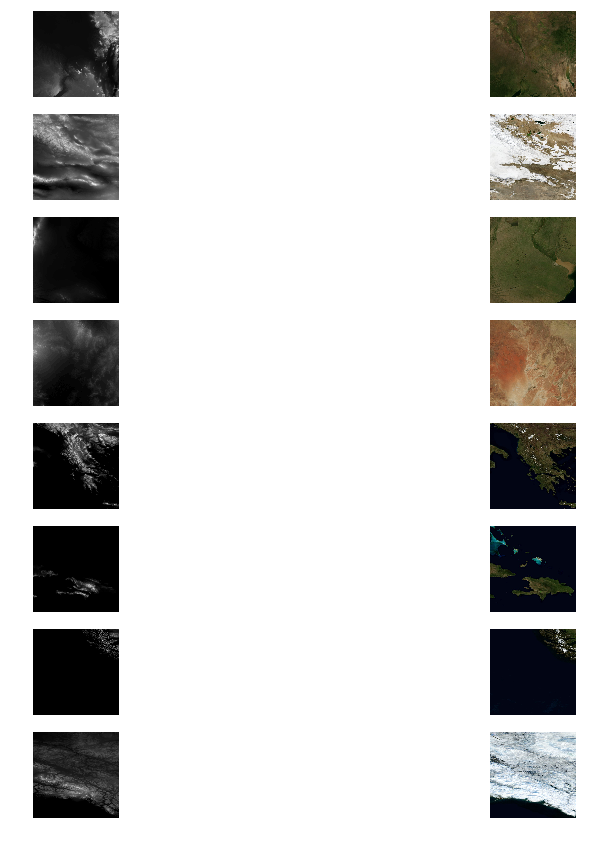

In [132]:
plt.figure(figsize=(15,30))
for b in range(0,16,2):
    plt.subplot(16,2, b+1)
    plt.imshow(X_batch[b,0],cmap="gray")
    plt.axis('off')
    plt.subplot(16,2, b+2)
    plt.imshow(Y_batch[b].swapaxes(0,1).swapaxes(1,2))
    plt.axis('off')

Compute the mean 'mean'

In [156]:
X_mean, X_std = 0, 0
Y_mean, Y_std = 0, 0
n_batches = 0
for X_batch, Y_batch in iterate_hdf5(None)(dataset['heightmaps'], dataset['textures'], bs=32):
    n_batches += 1
    X_mean += np.mean(X_batch)
    X_std += np.std(X_batch)
    Y_mean += np.mean(Y_batch)
    Y_std += np.std(Y_batch)
X_mean /= n_batches
X_std /= n_batches
Y_mean /= n_batches
Y_std /= n_batches

In [157]:
X_mean, X_std, Y_mean, Y_std

(25.904849699354056,
 39.261372849783811,
 106.54810293305763,
 96.274225403759615)

Ok let's do some pre-normalisation

In [196]:
#img_gen = ImageDataGenerator(rescale=1./255.)

In [219]:
X_batch_norm, Y_batch_norm = \
    (X_batch.astype("float32") - X_mean) / X_std, \
    (Y_batch.astype("float32") - Y_mean) / Y_std

In [204]:
# yes it works
#X_batch_norm_unnorm = (X_batch_norm*X_std) + X_mean
#Y_batch_norm_unnorm = (Y_batch_norm*Y_std) + Y_mean

Play around with the data augmentation

In [209]:
img_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

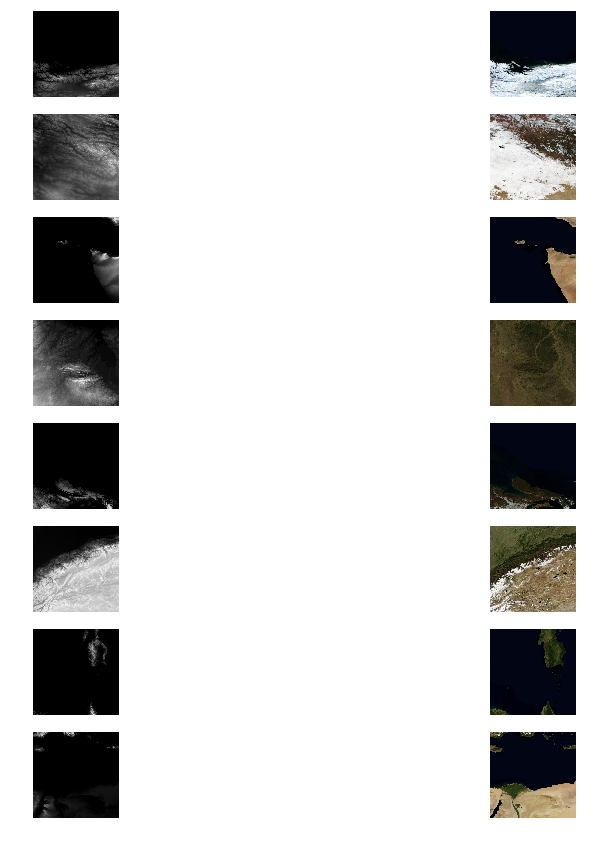

In [220]:
# we need to use the same seed for this augment, so find one before
s = np.random.randint(0,10000)
X_batch_norm_augment, Y_batch_norm_augment = \
    img_gen.flow(X_batch_norm, None, batch_size=32, shuffle=False, seed=s).next(), \
    img_gen.flow(Y_batch_norm, None, batch_size=32, shuffle=False, seed=s).next()
plt.figure(figsize=(15,30))
for b in range(0,16,2):
    plt.subplot(16,2, b+1)
    plt.imshow( ((X_batch_norm_augment[b,0]*X_std)+X_mean).astype("uint8"),cmap="gray")
    plt.axis('off')
    plt.subplot(16,2, b+2)
    plt.imshow( ((Y_batch_norm_augment[b].swapaxes(0,1).swapaxes(1,2)*Y_std)+Y_mean).astype("uint8"))
    plt.axis('off')

------------

### Do the entire iterator here

In [225]:
def iterate_hdf5(imgen=None, X_mean=0, Y_mean=0, X_std=0, Y_std=0):
    def _iterate_hdf5(X_arr, y_arr, bs, rnd_state=np.random.RandomState(0)):
        assert X_arr.shape[0] == y_arr.shape[0]
        slices = _get_slices(X_arr.shape[0], bs)
        if rnd_state != None:
            rnd_state.shuffle(slices)
        for elem in slices:
            this_X, this_Y = X_arr[elem], y_arr[elem]
            this_X = this_X.swapaxes(3,2).swapaxes(2,1)
            this_Y = this_Y.swapaxes(3,2).swapaxes(2,1)
            # normalise
            this_X = (this_X - X_mean) / X_std
            this_Y = (this_Y - Y_mean) / Y_std
            # if we passed an image generator, augment the images
            if imgen != None:
                seed = rnd_state.randint(0, 100000)
                this_X = imgen.flow(this_X, None, batch_size=bs, seed=seed).next()
                this_Y = imgen.flow(this_Y, None, batch_size=bs, seed=seed).next()              
            yield this_X, this_Y
    return _iterate_hdf5

In [226]:
rnd_seed = np.random.randint(0,10000)
img_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
itr = iterate_hdf5(img_gen, X_mean, Y_mean, X_std, Y_std)

In [232]:
for X_batch_test, Y_batch_test in itr(dataset['heightmaps'], dataset['textures'], bs=32):
    print X_batch_test.shape, Y_batch_test.shape
    break

(32, 1, 512, 512) (32, 3, 512, 512)


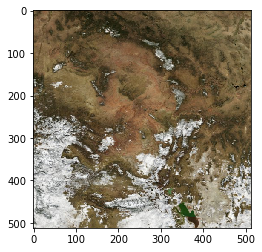

In [252]:
plt.imshow(  ((Y_batch_test[4].swapaxes(0,1).swapaxes(1,2)*Y_std)+Y_mean).astype("uint8")  )

In [176]:
X_batch_augment, Y_batch_augment = \
    img_gen.flow(X_batch_norm, None, batch_size=32).next(), \
    img_gen.flow(Y_batch_norm, None, batch_size=32).next()

-----

In [283]:
class Hdf5Iterator():
    def __init__(self):
        self.b = 0
    def __iter__(self,2):
        return self

    def next(self):
        self.b += 1
        return self.b+

In [284]:
def test():
    for i in range(10):
        yield i

In [274]:
itr = test

In [279]:
itr.N = 10

In [285]:
for elem in Hdf5Iterator():
    print elem

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

In [282]:
itr

<function __main__.test>